# Uczenie głębokie

Jacek Rumiński, Politechnika Gdańska, Wydział ETI, Katedra Inżynierii Biomedycznej

**Wykład 10:** Modele przeciwstawne - GAN

**Przykład (1):** GAN


Zróbmy eksperymenty z modelem GAN dla obrazów MNIST.


In [ ]:
# Read packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, losses



print(tf.__version__)

2.14.0


True original label : 1


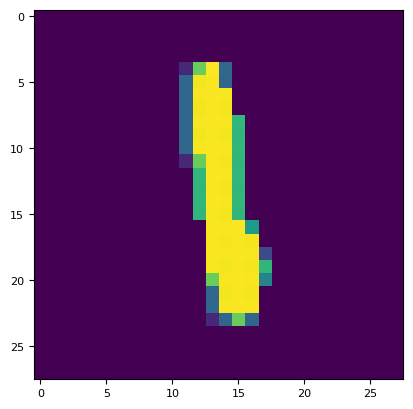

In [ ]:
# Load data and split to training and test datasets

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Data properties
image_width = 28;
image_height = 28;
image_components = 1
img_shape = (image_height, image_width, image_components)
latent_space_dim = 100

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


# Normalize values between -1 and 1
x_train = x_train / 127.5 - 1.
x_test = x_test / 127.5 - 1.

# Merge both in the future - not test data required

batch_size = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)


# Show an example
example = 200
class_id = y_train[example].item()

plt.rcParams["axes.grid"] = False
plt.imshow((x_train[example]/2.0)+0.5)
print("True original label :", class_id)


In [ ]:
generator = tf.keras.models.Sequential([

    layers.Dense(256, input_shape=[latent_space_dim],
                       activation=layers.LeakyReLU(alpha=0.2)),
    layers.BatchNormalization(momentum=0.8),

    layers.Dense(512, activation=layers.LeakyReLU(alpha=0.2)),
    layers.BatchNormalization(momentum=0.8),

    layers.Dense(1024, activation=layers.LeakyReLU(alpha=0.2)),
    layers.BatchNormalization(momentum=0.8),

    layers.Dense(np.prod(img_shape), activation='tanh'),
    layers.Reshape(img_shape),


], name="generator")


In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               25856     
                                                                 
 batch_normalization_12 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_13 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 1024)              525312    
                                                                 
 batch_normalization_14 (Ba  (None, 1024)              40

In [ ]:
discriminator = tf.keras.models.Sequential([

    layers.Flatten(input_shape=img_shape),
    layers.Dense(512, activation=layers.LeakyReLU(0.2)),
    layers.Dense(256, activation=layers.LeakyReLU(0.2)),

    layers.Dense(1, activation="sigmoid"),
], name="discriminator")


In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               401920    
                                                                 
 dense_24 (Dense)            (None, 256)               131328    
                                                                 
 dense_25 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 533505 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
GAN = tf.keras.models.Sequential([generator, discriminator])

In [ ]:
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_D, metrics=['accuracy'])

discriminator.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer=optimizer_G)

In [ ]:
GAN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Sequential)      (None, 28, 28, 1)         1493520   
                                                                 
 discriminator (Sequential)  (None, 1)                 533505    
                                                                 
Total params: 2027025 (7.73 MB)
Trainable params: 1489936 (5.68 MB)
Non-trainable params: 537089 (2.05 MB)
_________________________________________________________________


In [ ]:
def show_examples(fake):
  matplotlib.rcParams.update({'font.size': 8})
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(6,12))

  ax1.set_title("Fake")
  ax1.imshow(fake[0])

  ax2.set_title("Fake")
  ax2.imshow(fake[1])

  ax3.set_title("Fake")
  ax3.imshow(fake[2])

  ax4.set_title("Fake")
  ax4.imshow(fake[3])

  plt.show()

In [ ]:
def train(gan, dataset, random_normal_dimensions, batch_size=64, n_epochs=30):
    # Ground truths for the supervised learning of the discriminator
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    # Please do experiments to make the labels smooth, e.g. real-> 0.8-1.0

    generator, discriminator = gan.layers

    d_loss_values = []
    g_loss_values = []

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:

            # Train the discriminator on real images
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real_images, real)

            # Train the discriminator on fake images
            # Generate z values
            z_values = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            # Generate images for a current batch and fake discriminator
            fake_images = generator.predict(z_values, verbose=0)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake)

            # Combine final loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator
            z_values = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            # Freeze the discriminator to train only generator
            discriminator.trainable = False
            # label flip -> generated are "real", fool D to get ones
            g_loss = GAN.train_on_batch(z_values, real)


            # Store loss values
            d_loss_values.append(d_loss)
            g_loss_values.append(g_loss)

        # Plot the fake images
        show_examples(((fake_images/2.0)+0.5))

        print ("Epoch: %d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    return g_loss_values, d_loss_values


Epoch 1/30


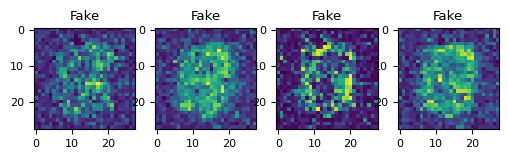

Epoch: 0 [Discriminator loss: 0.670864, acc.: 46.09%] [Generator loss: 0.745287]
Epoch 2/30


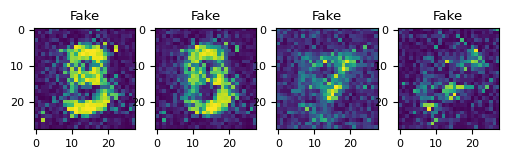

Epoch: 1 [Discriminator loss: 0.615076, acc.: 65.23%] [Generator loss: 0.927800]
Epoch 3/30


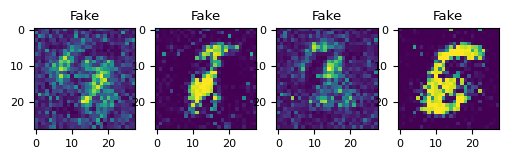

Epoch: 2 [Discriminator loss: 0.547907, acc.: 80.08%] [Generator loss: 1.066610]
Epoch 4/30


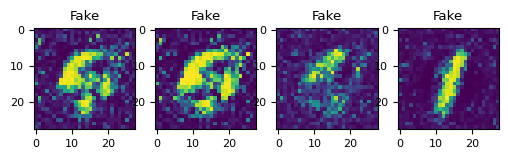

Epoch: 3 [Discriminator loss: 0.571842, acc.: 69.14%] [Generator loss: 1.165808]
Epoch 5/30


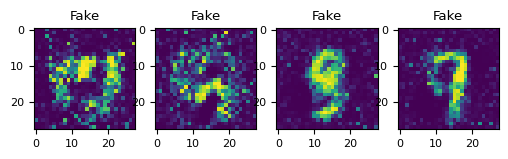

Epoch: 4 [Discriminator loss: 0.555427, acc.: 70.31%] [Generator loss: 1.003268]
Epoch 6/30


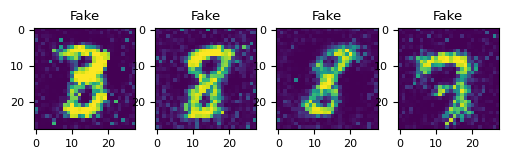

Epoch: 5 [Discriminator loss: 0.562088, acc.: 73.44%] [Generator loss: 1.062726]
Epoch 7/30


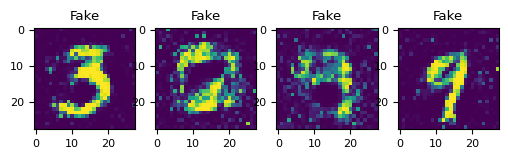

Epoch: 6 [Discriminator loss: 0.575075, acc.: 72.27%] [Generator loss: 1.012516]
Epoch 8/30


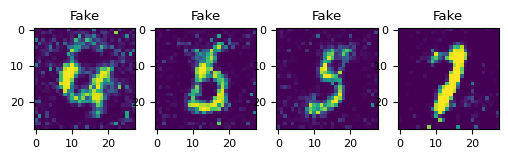

Epoch: 7 [Discriminator loss: 0.572398, acc.: 70.70%] [Generator loss: 1.005349]
Epoch 9/30


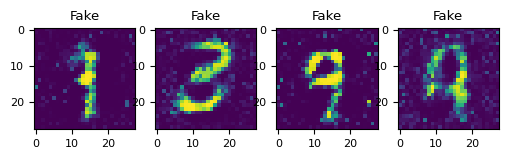

Epoch: 8 [Discriminator loss: 0.595519, acc.: 66.02%] [Generator loss: 0.907672]
Epoch 10/30


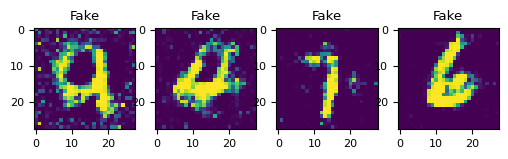

Epoch: 9 [Discriminator loss: 0.600049, acc.: 68.75%] [Generator loss: 0.998127]
Epoch 11/30


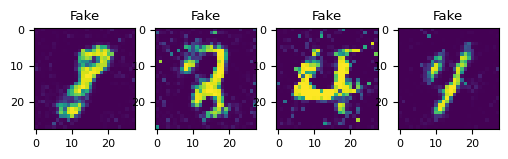

Epoch: 10 [Discriminator loss: 0.627544, acc.: 62.50%] [Generator loss: 0.960993]
Epoch 12/30


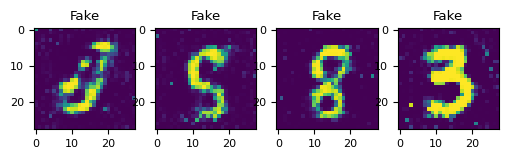

Epoch: 11 [Discriminator loss: 0.653280, acc.: 61.33%] [Generator loss: 0.904080]
Epoch 13/30


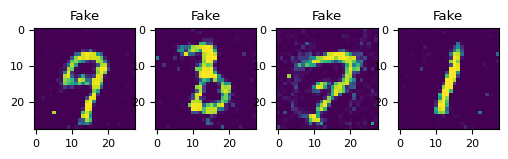

Epoch: 12 [Discriminator loss: 0.601984, acc.: 71.88%] [Generator loss: 0.881649]
Epoch 14/30


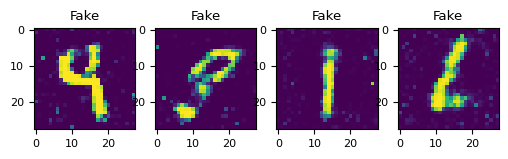

Epoch: 13 [Discriminator loss: 0.678286, acc.: 57.42%] [Generator loss: 0.907326]
Epoch 15/30


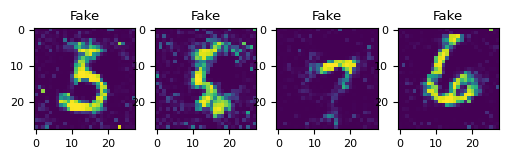

Epoch: 14 [Discriminator loss: 0.650295, acc.: 61.72%] [Generator loss: 0.901289]
Epoch 16/30


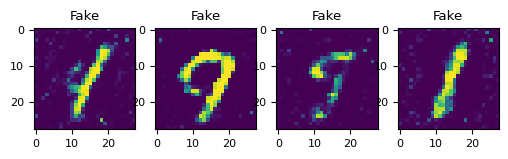

Epoch: 15 [Discriminator loss: 0.609076, acc.: 70.31%] [Generator loss: 0.986244]
Epoch 17/30


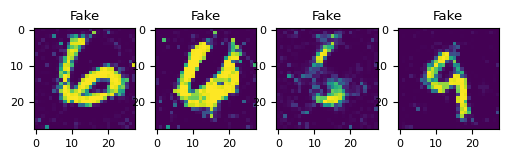

Epoch: 16 [Discriminator loss: 0.630133, acc.: 63.67%] [Generator loss: 0.928705]
Epoch 18/30


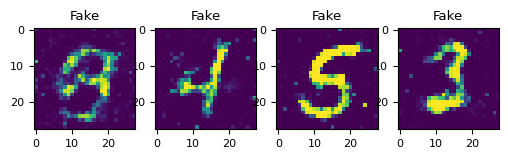

Epoch: 17 [Discriminator loss: 0.658394, acc.: 63.67%] [Generator loss: 0.913657]
Epoch 19/30


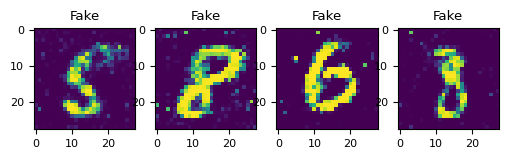

Epoch: 18 [Discriminator loss: 0.627612, acc.: 67.58%] [Generator loss: 0.875435]
Epoch 20/30


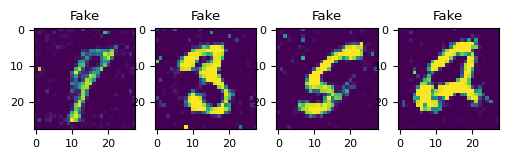

Epoch: 19 [Discriminator loss: 0.667430, acc.: 57.03%] [Generator loss: 0.903595]
Epoch 21/30


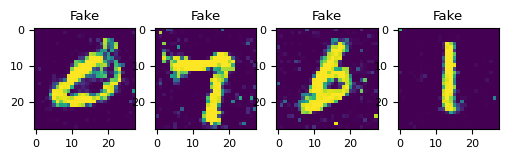

Epoch: 20 [Discriminator loss: 0.646753, acc.: 65.23%] [Generator loss: 0.935202]
Epoch 22/30


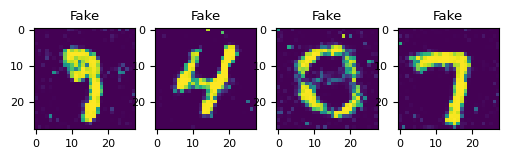

Epoch: 21 [Discriminator loss: 0.672970, acc.: 59.38%] [Generator loss: 0.920112]
Epoch 23/30


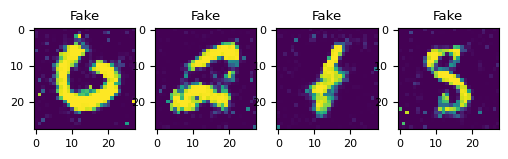

Epoch: 22 [Discriminator loss: 0.655637, acc.: 62.89%] [Generator loss: 0.935889]
Epoch 24/30


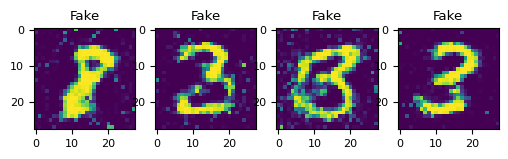

Epoch: 23 [Discriminator loss: 0.635168, acc.: 63.28%] [Generator loss: 0.887225]
Epoch 25/30


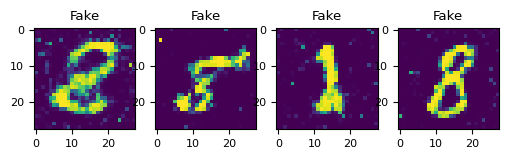

Epoch: 24 [Discriminator loss: 0.631896, acc.: 65.23%] [Generator loss: 0.930456]
Epoch 26/30


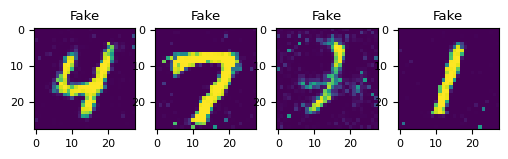

Epoch: 25 [Discriminator loss: 0.607115, acc.: 69.92%] [Generator loss: 0.908601]
Epoch 27/30


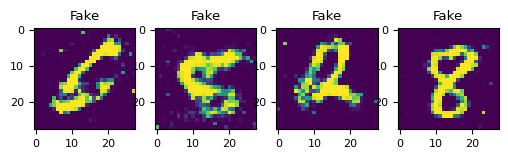

Epoch: 26 [Discriminator loss: 0.674076, acc.: 58.20%] [Generator loss: 0.920620]
Epoch 28/30


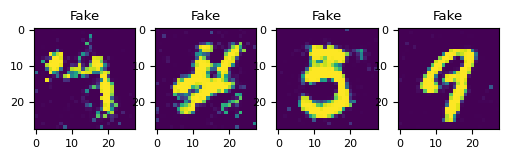

Epoch: 27 [Discriminator loss: 0.641317, acc.: 64.45%] [Generator loss: 0.949647]
Epoch 29/30


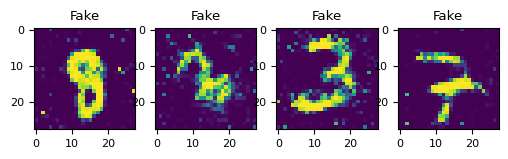

Epoch: 28 [Discriminator loss: 0.652552, acc.: 60.55%] [Generator loss: 0.902144]
Epoch 30/30


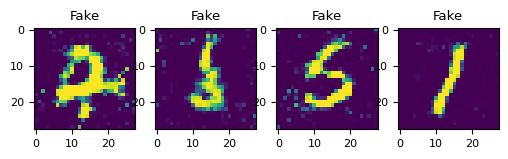

Epoch: 29 [Discriminator loss: 0.667816, acc.: 61.33%] [Generator loss: 0.918530]


In [ ]:
g_losses, d_losses = train(GAN, dataset, latent_space_dim, batch_size, 30)

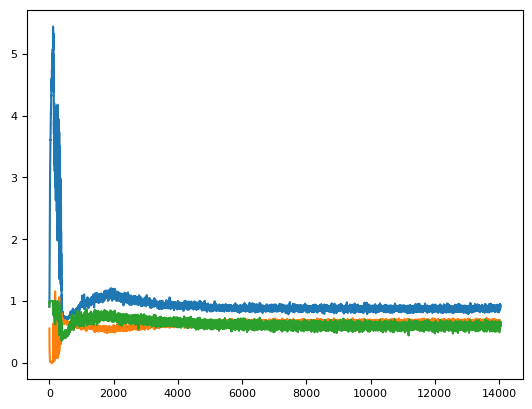

In [ ]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(g_losses)), g_losses, label='Generator loss')
ax1.plot(range(len(d_losses)), d_losses, label='Discriminator loss')
plt.show()
